In [1]:
import numpy as np
import math
import torch
from torch import nn

import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

from Models import BigGenerator

from datetime import datetime

from torch.utils.data import Dataset

from Models import get_mlp
from Tools import NormalLogLikelihood
from torch.distributions.multivariate_normal import MultivariateNormal


from Experiments import get_setup

from Inference.IVI import IVI

from tqdm import trange

import timeit

In [12]:
def KL(theta0, theta1, k=1, device='cpu', p=2):
    """
        Parameters:
            theta0 (Tensor): Samples, P X NbDimensions
            theta1 (Tensor): Samples, R X NbDimensions
            k (Int): positive ordinal number

        Returns:
            (Float) k-Nearest Neighbour Estimation of the KL from theta0 to theta1

        Kullback-Leibler Divergence Estimation of Continuous Distributions Fernando Pérez-Cruz
        """

    n0 = theta0.shape[0]
    n1 = theta1.shape[0]
    dim0 = theta0.shape[1]
    dim1 = theta1.shape[1]
    assert dim0 == dim1

    D0 = torch.cdist(theta0, theta0, p=p)
    D1 = torch.cdist(theta0, theta1, p=p)

    a0 = torch.topk(D0, k=k + 1, dim=1, largest=False, sorted=True)[0][:,k]  # .clamp(torch.finfo().eps,float('inf')).to(device)
    a1 = torch.topk(D1, k=k, dim=1, largest=False, sorted=True)[0][:,k - 1]  # .clamp(torch.finfo().eps,float('inf')).to(device)

    assert a0.shape == a1.shape, 'dimensions do not match'

    d = torch.as_tensor(float(dim0), device=device)
    N0 = torch.as_tensor(float(n0), device=device)
    N1 = torch.as_tensor(float(n1), device=device)

    Mnn = (torch.log(a1) - 0.54*torch.log(a0)).mean()
    return d * Mnn + N1.log() - (N0 - 1).log()

In [13]:
#hyperparameters

#predictive model
layerwidth=50
nblayers=1
activation=nn.ReLU()

#generative model
lat_dim=5







#loss hyperparameters
n_samples_LL=100 #nb of predictor samples for average LogLikelihood

n_samples_KL=1000 #nb of predictor samples for KL divergence
kNNE=1 #k-nearest neighbour



In [14]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
#date_string = datetime.now().strftime("%Y-%m-%d-%H:%M")

device(type='cuda', index=0)

# Setup #

In [15]:
class GaussianProcess(nn.Module):
    def __init__(self, mean, lengthscale):
        super(GaussianProcess, self).__init__()
        self.ls=lengthscale
        self.mean=mean

    def covar_matrix(self,x):
        return torch.exp(-torch.cdist(x,x,p=2)/(2*self.ls**2))
    
    def log_prob(self,inputs,f):
        GP_inputs=MultivariateNormal(loc=self.mean*torch.ones(inputs.shape[0], device=inputs.device),covariance_matrix=self.covar_matrix(inputs))
        return GP_inputs.log_prob(f)
    def forward(self, inputs, n=1):
        GP_inputs=MultivariateNormal(loc=self.mean*torch.ones(inputs.shape[0], device=inputs.device),covariance_matrix=self.covar_matrix(inputs))
        return GP_inputs.sample((n,)).squeeze()
    
    
input_dim=1

target=GaussianProcess(mean=torch.tensor(0.),lengthscale=1.).to(device)



# Predictive model #

In [16]:
layerwidth=50
nb_layers=1
activation=nn.Tanh()
param_count, model = get_mlp(input_dim, layerwidth, nblayers, activation)

param_count

151

# ELBO

## Kullback-Leibler divergence in Predictor space

In [17]:

# sampling of OOD inputs on which evaluate predictors for the Hilbert distance
"""
##for toy example
n_samples_FU=30
def projection(theta0,theta1):
    #batch sample OOD    
    M=2.
    m=-2.
    X_ood = torch.rand(n_samples_FU,input_dim).to(device) * (M-m) + m    
    X=X_ood
    #compute projection on both paramters with model
    theta0_proj=model(X, theta0).squeeze(2)
    theta1_proj=model(X, theta1).squeeze(2)
    return theta0_proj, theta1_proj
"""
#predictor space KL




def projection(theta0):
    #batch sample OOD   
    n_ood=20
    M = 2.
    m = -2.
    X_ood = torch.rand(n_ood,input_dim).to(device) * (M-m) + m    #torch.linspace(-2,2.,100).unsqueeze(-1).to(device)#
    
    #compute projection on both paramters with model
    theta0_proj=model(X_ood, theta0).squeeze(2)
    theta1_proj=target(X_ood,theta0.shape[0]).to(device)
    return theta0_proj, theta1_proj

def kl(GeN):

    theta=GeN(n_samples_KL) #variationnel

    theta_proj, theta_prior_proj = projection(theta)

    K=KL(theta_proj, theta_prior_proj,k=kNNE,device=device)
    return K


def NNE(theta,k=1,k_MC=1,device='cpu'):
    """
    Parameters:
        theta (Tensor): Samples, NbExemples X NbDimensions
        k (Int): ordinal number

    Returns:
        (Float) k-Nearest Neighbour Estimation of the entropy of theta

    """
    nb_samples=theta.shape[0]
    dim=theta.shape[1]
    D=torch.cdist(theta,theta)
    a = torch.topk(D, k=k+1, dim=0, largest=False, sorted=True)[0][k].clamp(torch.finfo().eps,float('inf')).to(device)
    d=torch.as_tensor(float(dim), device=device)
    K=torch.as_tensor(float(k), device=device)
    K_MC=torch.as_tensor(float(k_MC), device=device)
    N=torch.as_tensor(float(nb_samples), device=device)
    pi=torch.as_tensor(math.pi, device=device)
    lcd = d/2.*pi.log() - torch.lgamma(1. + d/2.0)-d/2*K_MC.log()
    return torch.log(N) - torch.digamma(K) + lcd + d/nb_samples*torch.sum(torch.log(a))

def kl_(GeN):
    theta=GeN(n_samples_KL) #variationnel
    n_ood=100
    M = 2.
    m = -2.
    X_ood = torch.linspace(-2,2.,n_ood).unsqueeze(-1).to(device)#torch.rand(n_ood,input_dim).to(device) * (M-m) + m  
    f_theta=model(X_ood, theta).squeeze(2)
    H=NNE(f_theta,k_MC=n_ood)
    logtarget=target.log_prob(X_ood,f_theta).mean()
    return -H-logtarget


# Generative model #

In [29]:
#generative model
GeN = BigGenerator(lat_dim,param_count,device).to(device)
print(GeN)

torch.nn.init.normal_(GeN.model[4].weight,mean=0., std=1.)
torch.nn.init.normal_(GeN.model[4].bias,mean=0., std=1.)



BigGenerator(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=20, out_features=40, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=40, out_features=151, bias=True)
  )
)


Parameter containing:
tensor([-0.2162, -0.7315,  0.9823,  0.3094,  1.4356,  1.1753, -0.7621, -0.7540,
        -1.0245,  1.9976, -0.7172, -1.2932, -0.5185, -1.4295,  2.1533, -1.7807,
        -1.4366,  0.2494, -1.4543,  1.3361,  1.3188, -0.1299, -0.7196, -1.2822,
        -0.3632,  0.9609,  0.8955, -0.1445, -0.0883,  1.8116, -0.7818, -0.0062,
        -0.0074, -0.1338, -0.3369,  0.1507, -1.0323, -1.0602,  1.7471,  1.2894,
        -0.9628,  1.5174,  0.5316,  0.3108, -0.7056, -0.4355,  0.1337,  1.0801,
         0.1285,  0.0964,  0.8997, -0.2860,  0.1303,  0.2110, -0.4478,  0.7991,
        -0.3923, -1.2269, -0.6014,  0.3046,  0.6432, -1.7766, -0.1980, -0.4316,
         0.4979,  0.5074,  0.6105,  0.0473, -1.8784, -0.2620,  0.5053,  0.4376,
         0.0388, -0.3268,  2.5338, -0.9904, -0.3444, -0.2031, -0.4514,  0.2509,
         0.6233,  0.2462, -1.5091, -0.5036, -0.9945, -1.0122,  1.2449, -0.4055,
        -1.3571,  0.5101, -0.9268, -2.0145, -1.5374,  0.4479, -0.6600, -1.3424,
         0.1258, -

In [30]:
kl_(GeN)

tensor(503.5240, device='cuda:0', grad_fn=<SubBackward0>)

# Optimizer

In [31]:
class IVI():
    def __init__(self, KL, optimizer):
        
        self.loss=KL
        self.optimizer=optimizer

    def run(self, GeN):

        GeN.train(True)
        with torch.enable_grad():

            self.optimizer.zero_grad()

            K=self.loss(GeN)
#            H,logtarget=self.loss(GeN)
#            K=-H-logtarget
            K.backward()

            lr = self.optimizer.param_groups[0]['lr']

            self.optimizer.step()

        return K.item(),lr #K.item(), H.item(), logtarget.item(), lr


#optimizer
learning_rate=0.01
optimizer = torch.optim.Adam(GeN.parameters(), lr=learning_rate)

Run=IVI(kl,optimizer)

# Scheduler #

In [32]:
#scheduler
patience=1000
lr_decay=.5#.7
min_lr= 1e-6
n_epochs=20000#2000

#scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=lr_decay, verbose=True, min_lr=min_lr)


# TRAINING #

In [33]:
KLs=[]

start = timeit.default_timer()
with trange(n_epochs) as tr:
    for t in tr:
        
        theta=GeN(1000).detach()
        
        K, lr=Run.run(GeN)
        tr.set_postfix(KL=K)#, H=H,logtarget=logtarget, lr=lr)
        KLs.append(K)

        scheduler.step(K)
        if lr <= 1e-4:
            break
stop = timeit.default_timer()
execution_time = stop - start



 21%|██▏       | 4277/20000 [00:41<02:33, 102.68it/s, KL=5.67]

Epoch  4262: reducing learning rate of group 0 to 5.0000e-03.


 29%|██▉       | 5784/20000 [00:55<02:13, 106.11it/s, KL=4.74]

Epoch  5770: reducing learning rate of group 0 to 2.5000e-03.


 35%|███▍      | 6998/20000 [01:07<01:59, 108.82it/s, KL=4.7] 

Epoch  6981: reducing learning rate of group 0 to 1.2500e-03.


 40%|███▉      | 7999/20000 [01:17<01:54, 104.36it/s, KL=4.67]

Epoch  7982: reducing learning rate of group 0 to 6.2500e-04.


 49%|████▉     | 9788/20000 [01:34<01:38, 103.50it/s, KL=4.82]

Epoch  9774: reducing learning rate of group 0 to 3.1250e-04.


 57%|█████▋    | 11406/20000 [01:50<01:19, 107.84it/s, KL=4.36]

Epoch 11389: reducing learning rate of group 0 to 1.5625e-04.


 62%|██████▏   | 12390/20000 [01:59<01:13, 103.79it/s, KL=4.25]

Epoch 12390: reducing learning rate of group 0 to 7.8125e-05.


17.14995132446289


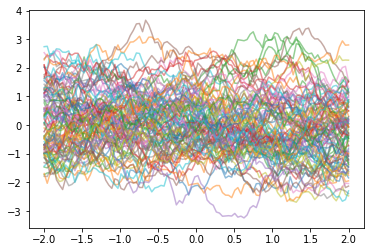

In [27]:
inputs=torch.linspace(-2,2.,100).unsqueeze(-1).to(device)
LPs=[]

for _ in range(100):
    f=target(inputs).cpu()
    plt.plot(inputs.cpu(),target(inputs).cpu(),alpha=0.5)
    LPs.append(target.log_prob(inputs.cpu(),f).item())
print(np.mean(LPs))

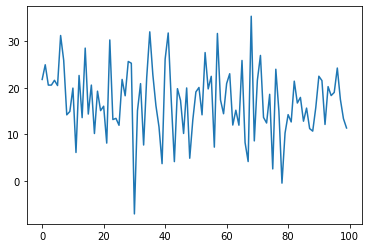

In [28]:
plt.plot(LPs)

59.55663017272949 2.4776464562176272


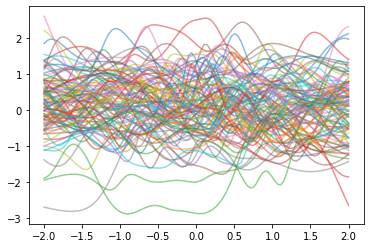

In [25]:
inputs=torch.linspace(-2,2.,100).unsqueeze(-1).to(device)
LPs=[]
for _ in range(100):
    f=model(inputs,GeN(1)).squeeze().detach().cpu()
    plt.plot(inputs.cpu(),model(inputs,GeN(1)).squeeze().detach().cpu(),alpha=0.5)
    LPs.append(target.log_prob(inputs.cpu(),f).item())
print(np.mean(LPs),np.std(LPs))    

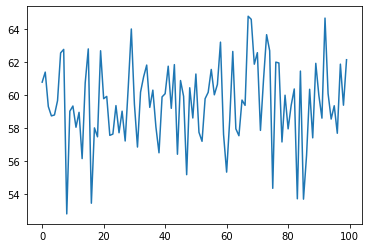

In [26]:
plt.plot(LPs)

19.30311637878418


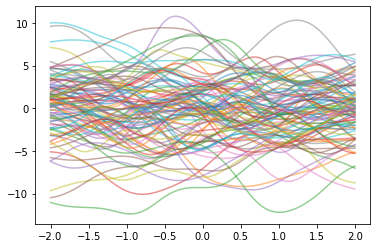

In [86]:
inputs=torch.linspace(-2,2.,100).unsqueeze(-1).to(device)
LPs=[]
for _ in range(100):
    f=model(inputs,GeN(1)).squeeze().detach().cpu()
    plt.plot(inputs.cpu(),model(inputs,GeN(1)).squeeze().detach().cpu(),alpha=0.5)
    LPs.append(target.log_prob(inputs.cpu(),f).item())
print(np.mean(LPs))    

-33.37973655700684


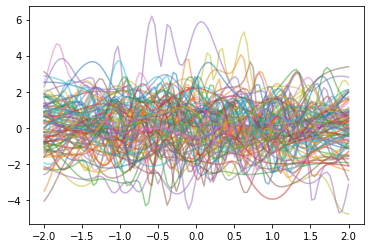

In [78]:
inputs=torch.linspace(-2,2.,100).unsqueeze(-1).to(device)
LPs=[]
for _ in range(100):
    f=model(inputs,GeN(1)).squeeze().detach().cpu()
    plt.plot(inputs.cpu(),model(inputs,GeN(1)).squeeze().detach().cpu(),alpha=0.5)
    LPs.append(target.log_prob(inputs.cpu(),f).item())
print(np.mean(LPs))    